# Objective
Predict bitcoin price by using historical data. The analysis result can be a reference for investment decision.

# Dataset: Yahoo Finance
https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install statsmodels
# !pip install -U scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

## Import test Data & Data cleansing

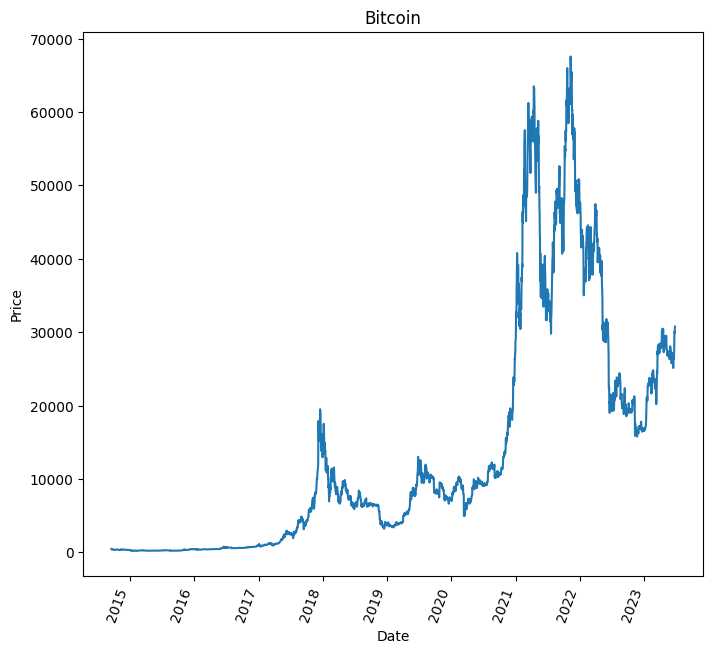

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [3]:
#import dataset
data = pd.read_csv('BTC-USD.csv')

#drop missing data
data = data.dropna()

#Turn UTC time format into date type
data['Date'] = pd.to_datetime(data['Date'])

#Turn date into index
data.set_index('Date', drop = True, inplace =True)

#Plot the graph
plt.figure(figsize = (8,8))
data.Close.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin')
plt.xticks(rotation = 70)
plt.show()

#Data exploration
data.head()

## Bitcoin price data is nonstationary
Autocorrelation function (ACF) is used for determinate whether bitcoin price is stationary or nonstationary. <br> 
Due to the autocorrelation is remain nearly +1, it represents a strong linear relationship between each observation and its lagged value. Bitcoin price suggests that the time series is highly persistent and exhibits a strong trend so that it is nonstationary time series <br> 

Therefore, nonstationary time series can make it difficult to model and predict the series using traditional time series methods that assume stationarity, such as ARIMA models or simple regression. It also violate the assumptions of Homoscedasticity of standard regression methods <br> 
(Homoscedasticity : The variance of the errors should be constant across all levels of the independent variables).

<function matplotlib.pyplot.show(close=None, block=None)>

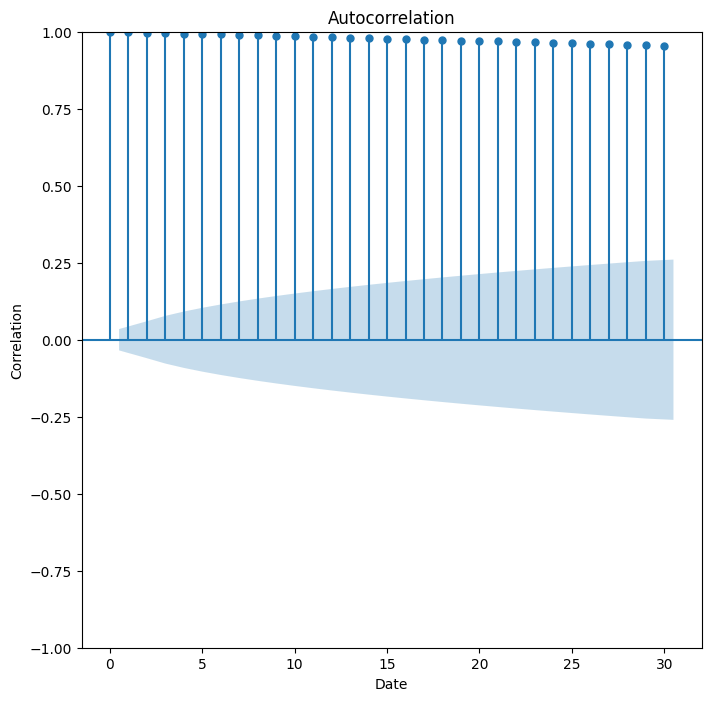

In [4]:
#Calculate the autocorrelation, 
fig, axes = plt.subplots(figsize = (8,8))
plot_acf(data.Close, axes, lags = 30)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show

# Use Differencing to turn bitcoin price from nonstationary to stationary time series
Differencing  can help to stabilise the variance of a time series and the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend 

If we change bitcoin price into precentage, we can get stationary time series. Therefore, due to stationary time series have a constant mean, variance, and autocorrelation structure over time, which allows for the use of standard regression methods such as ordinary least squares (OLS) and generalized linear models (GLMs) easier to model and make predictions.

Therefore, after removing the trend, The ACF decay to zero relatively quickly as the lag increases. It shows that the time series of bitcoin price is no persistent correlation between observations at different points in time so that it's stationary.

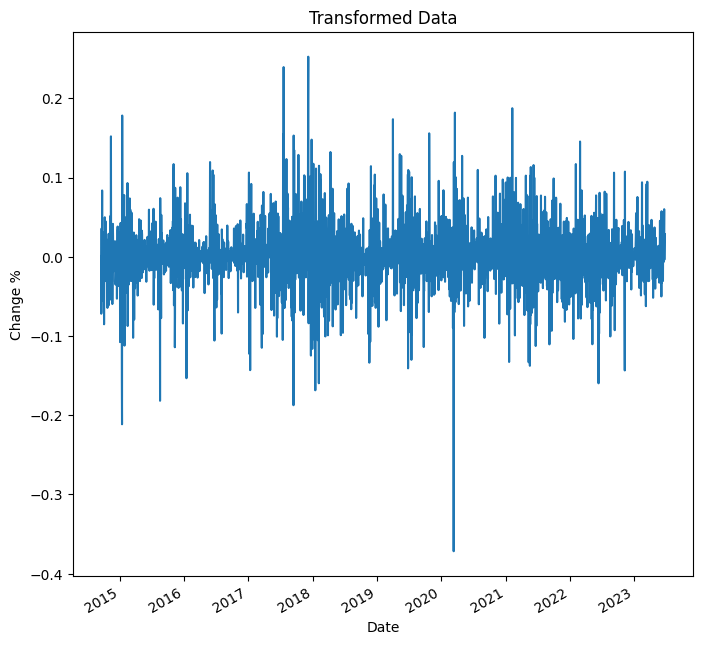

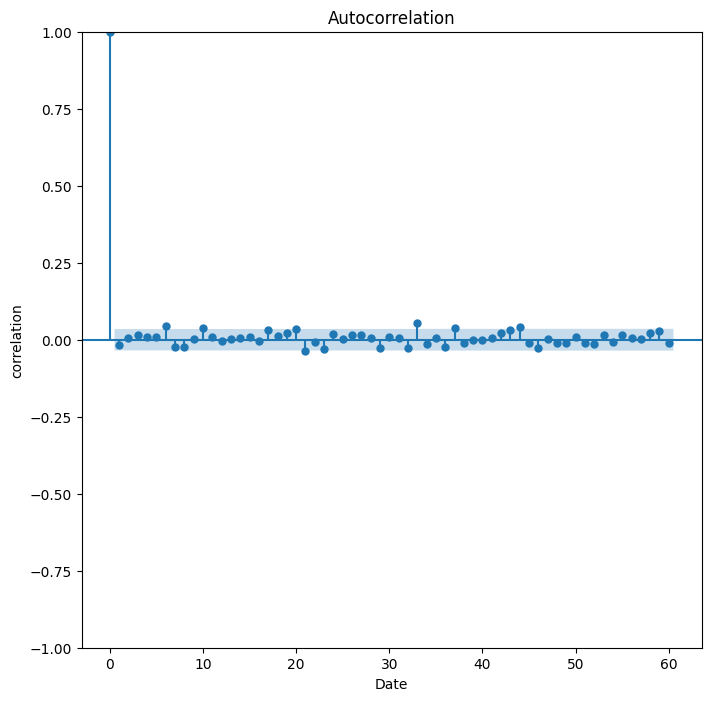

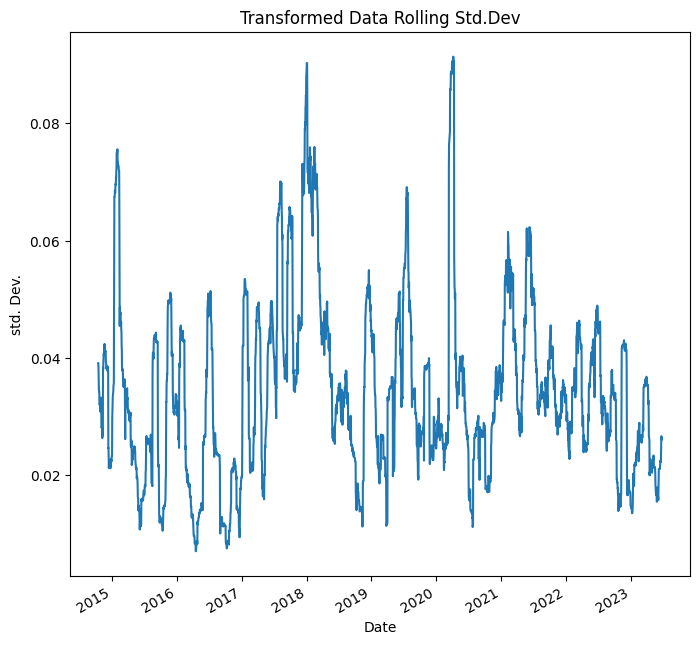

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Turn changes into percentage
data['diffs'] = (data.Close.diff() / data.Close.shift(periods = 1, fill_value = 0)).values
data['diffs'].fillna(0, inplace=True) # fill NaN values with 0

# convert masked elements to NaN values
data['diffs'] = np.ma.filled(data['diffs'], fill_value=np.nan)

#Plot graph
plt.figure(figsize = (8, 8))
data.diffs.plot()
plt.xlabel('Date')
plt.ylabel('Change %')
plt.title('Transformed Data')
plt.show()

#acf
fig, axes = plt.subplots(figsize = (8,8))
plot_acf(data.diffs, axes, lags=60)
plt.xlabel('Date')
plt.ylabel('correlation')
plt.show()

plt.figure(figsize = (8,8))
data.diffs.rolling(30).std().plot()
plt.xlabel('Date')
plt.ylabel('std. Dev.')
plt.title('Transformed Data Rolling Std.Dev')
plt.show()

# Apply Machine learning model 1 - Walk-forward validation

We use Mean Square Error and Sharpe Ratio as criteria to determine which model we should select. <br>
Least Mean square error and higher Sharpe ratio is better to select model.<br><br>


$\text{Sharpe Ratio} =\dfrac{\text{Profolio return}}{\text{Standard deviation of profolio return}}$


### Build attribute: We select past 20 days as attribute to predict next day bitcoin price.

In [6]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

np.random.seed(123456)
lr = LinearRegression()

#data preparation
diffs = (data.Close.diff() / data.Close.shift(periods = 1, fill_value = 0)).values[1:]
diff_len = len(diffs) # Total number of rows = 3199 days

#Build attribute
def create_x_data(lags = 1):
    diff_data = np.zeros((diff_len, lags)) #(3199, 20)
    
    for lag in range(1, lags + 1): #range(1-21)
        this_data = diffs[:-lag] #0-->-1. 0-->-2
        diff_data[lag:, lag-1] = this_data #1:last row,0 --> 2:last row,1 
    return diff_data

# Turn diff_data into percenatge
x_data = create_x_data(lags = 20) * 100
y_data = diffs * 100

x_data = np.around(x_data, decimals = 8)
y_data = np.around(y_data, decimals = 8)

# Calculate profit
- buy_points = buy bitcoin point-in-time
- sell_points = sell bitcoin point-in-time

Rules of buy or sell bitcoin <br>
1. If percentage change of bitcoin > 0.5%, we invest \\$100 in bitcoin <br>
2. If percentage change of bitcoin < -0.5%, we sell \\$100 in bitcoin

Formula of calculate profit & loss
- If the buy_price is \\$4, we hold \\$100 (stake股份) can buy 25 units of bitcoin. (stake / buy_price)
- If the current_close price increase from \\$4 to \\$5, we can earn \\$1 in each bitcoin (current_close - last_close)
- Therefore, the profit is (current_close - last_close) * (stake / buy_price)    --> [price difference/unit of holding stock]

In [7]:
# Calculate Sharpe ratio
def simulate(data, preds):       
    buy_threshold = 0.5
    stake = 100

    true, pred, balances = [], [], []
    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0

    start_index = len(data) - len(preds) - 1
    # Calculate bitcoin predicted value
    for i in range(len(preds)):
        #last day bitcoin closing price
        last_close = data.Close[i+start_index - 1 ]
        #today day bitcoin closing price
        current_close = data.Close[i+start_index]
    
        #save current closing price
        true.append(current_close)
        #save current predict closing price
        #Use percentage change between last closing price and model predict price
        pred.append(last_close * (1 + preds[i] / 100))
    
        #Using predict bitcoin price to trade
        #Preduct the bitcoin price will increase and no holding bitcoin now
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = true[-1]
            buy_points.append(i)
    
        #Predict the bitcoin price will decrease and holding bitcoin now
        elif preds[i] < -buy_threshold and not buy_price == 0:
            unit = stake / buy_price
            profit = (current_close - buy_price) * unit
            balance += profit
            buy_price = 0
            sell_points.append(i)
        balances.append(balance)
        
    true = np.array(true)
    pred = np.array(pred)
    
    #plot the graph
    plt.figure(figsize = (8,8))
    plt.scatter(buy_points, true[buy_points] + 500, marker = 'x', label = 'buy')
    plt.scatter(sell_points, true[sell_points] - 500, marker = 'o', label = 'sell' , s=5)
    plt.plot(true, label = 'True', c = 'red')
    plt.plot(pred, label = 'pred', linestyle = '--', c= 'black')
    plt.title('Trades')
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (8, 8))
    plt.plot(balances)
    plt.title('Profit')
    plt.show()
    balance_df = pd.DataFrame(balances)
    print(pd)
    pct_returns = balance_df.diff()/stake
    pct_returns = pct_returns[pct_returns != 0].dropna()
    
    print('Sharpe: %.2f' % (np.mean(pct_returns) / np.std(pct_returns)))

### Training data: 150 days (around 5 months)
Each Training data will select past 20 days to predict next day bitcoin price.

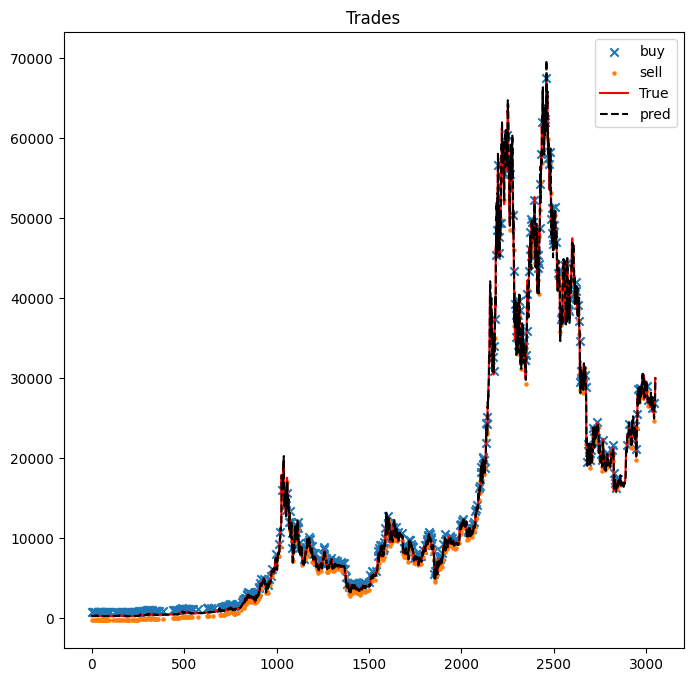

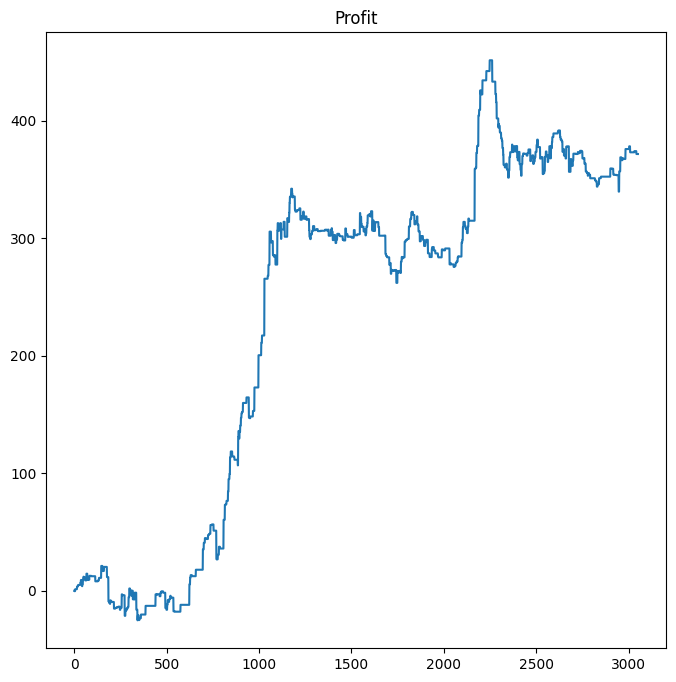

<module 'pandas' from 'C:\\Python-3105\\lib\\site-packages\\pandas\\__init__.py'>
Sharpe: 0.11
Percentages MSE: 16.76


In [8]:
#Train model
window = 150
preds = np.zeros(diff_len - window) #3199-150
for i in range(diff_len - window - 1):
    x_train = x_data[i : i + window, :]
    y_train = y_data[i : i + window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i + window + 1, :].reshape(1, -1))
    
simulate(data, preds)
print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds)) 

## Conclusion:
After my simulation of buy and sell bitcoin, we can calculate the sharpe ratio is 0.11

# Model 2 Soft Voting

In [9]:
# Use soft Voting to aggregate and optimize mean error

In [10]:
from copy import deepcopy

class VotingRegressor():

    #Receive learner
    def __init__(self, base_learners):
        self.base_learners = {}
        for name, learner in base_learners:
            self.base_learners[name] = deepcopy(learner)

    #Train specific learner
    def fit(self, x_data, y_data):
        for name in self.base_learners:
            learner = self.base_learners[name]
            learner.fit(x_data, y_data)
            
    # Make prediction
    def predict(self, x_data):
        predictions = np.zeros((len(x_data), len(self.base_learners)))
        names = list(self.base_learners.keys())

    #Every learners can do prediction
        for i in range(len(self.base_learners)):
            name = names[i]
            learner = self.base_learners[name]
    
            #put leaners prediction into specific places
            preds = learner.predict(x_data)
            predictions[:,i] = preds
    
        #calculate mean of each predictions
        predictions = np.mean(predictions, axis = 1)
        return predictions

#  I choose SVM, linear regression and KNN in model

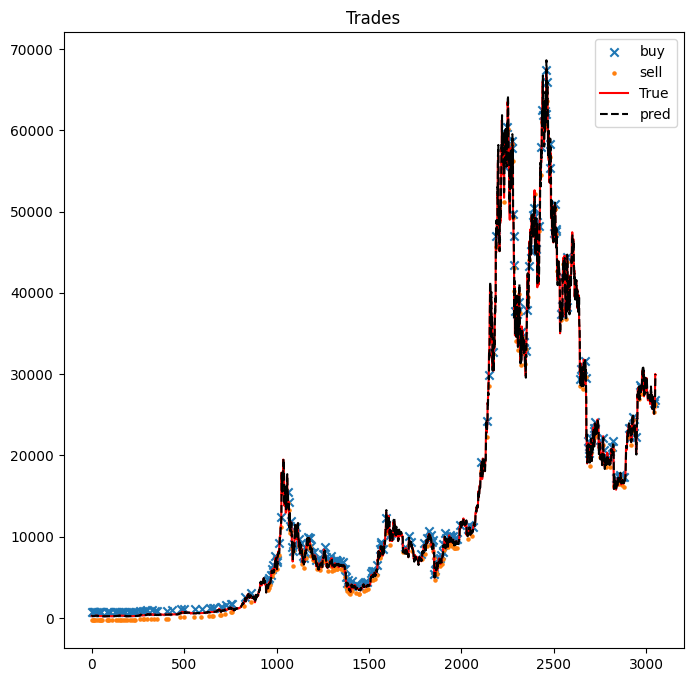

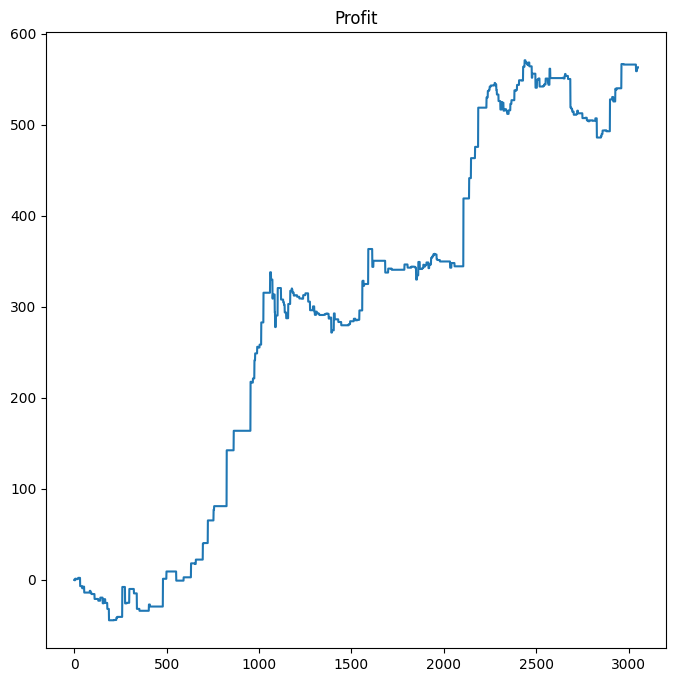

<module 'pandas' from 'C:\\Python-3105\\lib\\site-packages\\pandas\\__init__.py'>
Sharpe: 0.19
Percentages MSE: 14.34


In [11]:
# Import dictionaries

from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#Build model with Linear Regression
base_learners = [('SVR', SVR()), 
                 # ('LR', LinearRegression()), 
                 ('KNN', KNeighborsRegressor())]
lr = VotingRegressor(base_learners)

#train model
window = 150
preds = np.zeros(diff_len - window) #3199-150
for i in range(diff_len - window - 1):
    x_train = x_data[i : i + window, :]
    y_train = y_data[i : i + window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i + window + 1, :].reshape(1, -1))

simulate(data, preds)
print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))

## Conclusion
I select Voting to predict bitcoin price because it has higher sharpe ratio and lowest MSE

|Model |Sharpe |MSE |
| --- | --- | --- |Walk-forward validation| 0.11 |16.76 |
| Voting | 0.19 | 14.34 |3 | |  |2: 